In [1]:
# sciencey preamble
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn
seaborn.set(rc={"figure.figsize": (10, 8), "font.size": 12})

def matshow(mat, **kwargs):
    seaborn.heatmap(mat, square=True, xticklabels=50, yticklabels=50, **kwargs)

In [2]:
from conceptnet_retrofitting.loaders import *
from conceptnet_retrofitting.word_vectors import WordVectors
from conceptnet_retrofitting.builders.build_assoc import build_relations_from_conceptnet
from conceptnet_retrofitting.builders.label_set import LabelSet
from sklearn.preprocessing import normalize

/home/rspeer/.virtualenvs/lum3/lib/python3.5/site-packages/scikit_learn-0.16.1-py3.5-linux-x86_64.egg/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [3]:
PATH = '../build-data/'

In [4]:
labels = LabelSet(load_labels(PATH + 'glove.840B.300d.filtered.conceptnet5.labels'))
sparse_rels = build_relations_from_conceptnet(labels, '/wobbly/data/conceptnet5/assoc/reduced.csv')

In [5]:
cnglove = load_word_vectors(PATH + 'glove.840B.300d.filtered.conceptnet5.labels', PATH + 'glove.840B.300d.l1.filtered.conceptnet5.npy', PATH + 'wl1-replacements.msgpack')
#cnglove = load_word_vectors(PATH + 'multi-retrofit.labels', PATH + 'multi-retrofit.npy', PATH + 'wl1-replacements.msgpack')
glove = load_word_vectors(PATH + 'glove.840B.300d.standardized.labels', PATH + 'glove.840B.300d.l1.standardized.npy')

In [14]:
from conceptnet_retrofitting.builders.retrofit import dense_relation_array

In [7]:
rel_array = dense_relation_array(cnglove.vectors[:100000], {rel: sp[:100000, :100000] for (rel, sp) in sparse_rels.items()})

/home/rspeer/.virtualenvs/lum3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


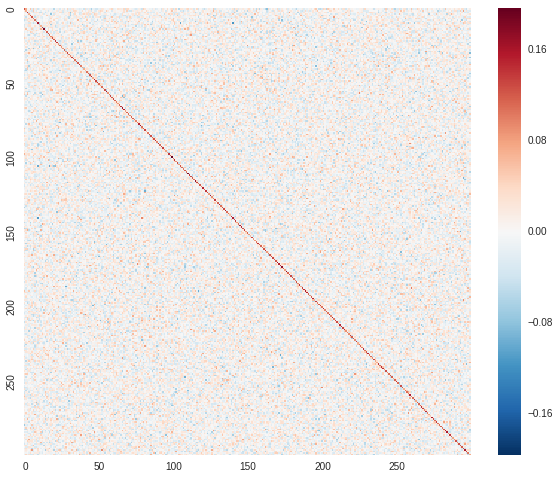

In [8]:
matshow(rel_array[-1])

In [9]:
def en_filter(term):
    return term.startswith('/c/en/')

In [10]:
rel_labels = sorted(sparse_rels)

In [11]:
def read_analogies(filename):
    for line in open(filename, encoding='utf-8'):
        line = line.rstrip()
        if not line or line.startswith('#'):
            continue
        parts = line.split('\t')
        inputs = parts[1:4]
        answers = parts[4:]
        yield inputs, answers

In [12]:
sym_rel_array = np.concatenate([rel_array, rel_array.swapaxes(1, 2)], axis=0)

In [13]:
rel_array.shape

(16, 300, 300)

In [20]:
any_rel = np.mean(cnglove.vectors, 0) @ rel_array @ np.mean(cnglove.vectors, 0)

In [21]:
def which_relation(wv, rar, c1, c2):
    rels = wv.to_vector(c2) @ rar @ wv.to_vector(c1)
    diff = np.maximum(0, rels - any_rel) ** 2
    diffsum = np.sum(diff)
    if diffsum > 0:
        diff /= diffsum
    return diff

In [22]:
def rank3_inner_product(vec, array3):
    return (array3 * vec[:, np.newaxis, np.newaxis]).sum(0)

In [23]:
def eval_analogy(wv, rar, c1, c2, c3, c4):
    if c4 in (c1, c2, c3):
        return 0.
    try:
        relA = which_relation(wv, rar, c1, c2)
        relB = which_relation(wv, rar, c1, c3)
        relAr = rank3_inner_product(relA, rar)
        relBr = rank3_inner_product(relB, rar)
        v1, v2, v3, v4 = [wv.to_vector(c) for c in (c1, c2, c3, c4)]
        numer1 = v4 @ relAr @ v3 + 1
        numer2 = v4 @ relBr @ v2 + 1
        denom1 = v4 @ relAr @ v1 + 1
        denom2 = v4 @ relBr @ v1 + 1
    except KeyError:
        return 0.
    return (numer1 ** 3 * numer2) / (denom1 + denom2)


In [24]:
def analogy(wv, rar, c1, c2, c3, num=20):
    relA = which_relation(wv, rar, c1, c2)
    relB = which_relation(wv, rar, c1, c3)
    print("RelA")
    for label, strength in zip(rel_labels + rel_labels, relA):
        print('\t%-20s\t% 7.1f' % (label, strength * 1000))
    print("RelB")
    for label, strength in zip(rel_labels + rel_labels, relB):
        print('\t%-20s\t% 7.1f' % (label, strength * 1000))
    relAr = rank3_inner_product(relA, rar)
    relBr = rank3_inner_product(relB, rar)
    v1, v2, v3 = [wv.to_vector(c) for c in (c1, c2, c3)]
    numer1 = wv.vectors @ (relAr @ v3) + 1
    numer2 = wv.vectors @ (relBr @ v2) + 1
    denom1 = wv.vectors @ (relAr @ v1) + 1
    denom2 = wv.vectors @ (relBr @ v1) + 1
    ratings = (numer1 ** 2 * numer2) / (denom1 + denom2)
    sortorder = np.argsort(-ratings)
    found = []
    for idx in sortorder:
        label = wv.labels[idx]
        if en_filter(label):
            found.append((label, ratings[idx]))
        if len(found) >= num:
            break
    return found

In [25]:
np.seterr(all='raise')
analogy(cnglove, rel_array, 'fire', 'hot', 'snow', num=20)

RelA
	/r/Antonym          	   49.1
	/r/AtLocation       	   33.8
	/r/AtLocation/back  	   26.7
	/r/Causes           	   12.4
	/r/Causes/back      	   99.6
	/r/HasProperty      	   45.1
	/r/HasProperty/back 	  193.6
	/r/HasSubevent      	   15.0
	/r/HasSubevent/back 	   13.5
	/r/IsA              	   55.6
	/r/IsA/back         	   55.2
	/r/PartOf           	   42.3
	/r/PartOf/back      	   40.7
	/r/RelatedTo        	  200.8
	/r/UsedFor          	   43.5
	/r/UsedFor/back     	   73.2
RelB
	/r/Antonym          	  390.1
	/r/AtLocation       	   26.1
	/r/AtLocation/back  	   67.7
	/r/Causes           	   41.6
	/r/Causes/back      	   49.8
	/r/HasProperty      	   42.0
	/r/HasProperty/back 	   31.8
	/r/HasSubevent      	   43.6
	/r/HasSubevent/back 	    0.9
	/r/IsA              	   50.8
	/r/IsA/back         	   33.8
	/r/PartOf           	   18.8
	/r/PartOf/back      	   29.3
	/r/RelatedTo        	   88.8
	/r/UsedFor          	   27.3
	/r/UsedFor/back     	   57.4


[('/c/en/snow', 1.1721938724698151),
 ('/c/en/winter', 1.0609728798193714),
 ('/c/en/cold', 1.056485144559435),
 ('/c/en/snowy', 1.0273789235680009),
 ('/c/en/chilly', 1.0173013926963861),
 ('/c/en/snowfall', 1.0151434568332902),
 ('/c/en/icy', 1.006988850188951),
 ('/c/en/sleet', 1.0069148745683794),
 ('/c/en/wintry', 1.0031931465779305),
 ('/c/en/frigid', 1.0001421556591159),
 ('/c/en/wintertime', 0.99731721814782537),
 ('/c/en/rainy', 0.98696083837549264),
 ('/c/en/frosty', 0.97407459866736545),
 ('/c/en/precipitation', 0.95744890104947522),
 ('/c/en/ice', 0.95229865634810729),
 ('/c/en/snow_cover', 0.95125275713333801),
 ('/c/en/rain', 0.94149670462521562),
 ('/c/en/weather', 0.93916923427769017),
 ('/c/en/snowstorm', 0.937904952632589),
 ('/c/en/warm', 0.92642573083154744)]

In [26]:
def analogy_3cosmul(wv, c1, c2, c3, num=20):
    sims1 = (wv.vectors @ wv.to_vector(c1)) + 1.000001
    sims2 = (wv.vectors @ wv.to_vector(c2)) + 1
    sims3 = (wv.vectors @ wv.to_vector(c3)) + 1
    ratings = sims2 * sims3 / (sims1)
    sortorder = np.argsort(-ratings)
    found = []
    for idx in sortorder:
        label = wv.labels[idx]
        if en_filter(label):
            found.append((label, ratings[idx]))
        if len(found) >= num:
            break
    return found


In [27]:
def eval_analogy_3cosmul(wv, c1, c2, c3, c4):
    try:
        v4 = wv.to_vector(c4)
        sim1 = v4 @ wv.to_vector(c1) + 1.000001
        sim2 = v4 @ wv.to_vector(c2) + 1
        sim3 = v4 @ wv.to_vector(c3) + 1
    except KeyError:
        return 0.
    return sim2 * (sim3 ** 2) / sim1

In [28]:
def eval_analogies(analogy_func, filename='/nfs/broadway/data/corpora/readtheory-analogies.txt'):
    total = 0
    correct = 0
    for inputs, answers in read_analogies(filename):
        # The 'inputs' are the three given components of the analogy.
        # 'answers' are the multiple-choice answers, where the correct answer is first in the list.
        best_score = 0.
        best_answer = ''
        for answer in answers:
            quad = inputs + [answer]
            score = analogy_func(*quad)
            if score >= best_score:
                best_score = score
                best_answer = answer
        total += 1
        if best_answer == answers[0]:
            correct += 1
        else:
            items = tuple(inputs + [best_answer.upper()] + [answers[0].upper()])
            print("%s : %s :: %s : %s (should be %s)" % items)
    print("Score: %2.2f%% (%d/%d)" % (correct / total * 100, correct, total))
    return correct / total

In [29]:
def curry_3cosmul(c1, c2, c3, c4):
    return eval_analogy_3cosmul(cnglove, c1, c2, c3, c4)

In [30]:
def curry_inferred(c1, c2, c3, c4):
    return eval_analogy(cnglove, rel_array, c1, c2, c3, c4)

In [31]:
print('\n3cosmul:')
eval_analogies(curry_3cosmul)
print('\ninferred relations:')
eval_analogies(curry_inferred)

print('\n3cosmul:')
eval_analogies(curry_3cosmul, filename='/nfs/broadway/data/corpora/learningexpress-analogies.txt')
print('\ninferred relations:')
eval_analogies(curry_inferred, filename='/nfs/broadway/data/corpora/learningexpress-analogies.txt')


3cosmul:
dirt : brown :: leaves : GRAY (should be GREEN)
shoes : feet :: helmet : ARMS (should be HEAD)
poor : money :: sad : FEELINGS (should be HAPPINESS)
banana : yellow :: carrot : RED (should be ORANGE)
now : later :: easy : SIMPLE (should be DIFFICULT)
lettuce : green :: strawberry : ORANGE (should be RED)
Score: 93.48% (86/92)

inferred relations:
shoes : feet :: helmet : ARMS (should be HEAD)
poor : money :: sad : FEELINGS (should be HAPPINESS)
lettuce : green :: strawberry : ORANGE (should be RED)
Score: 96.74% (89/92)

3cosmul:
train : board :: horse : STABLE (should be MOUNT)
hair : coif :: musical : PRAISE (should be SCORE)
fetish : fixation :: slight : CONFUSE (should be INSULT)
ragtime : United States :: raga : PIANO (should be INDIA)
obscene : coarse :: obtuse : OBSCURE (should be STUPID)
diamond : baseball :: court : JURY (should be SQUASH)
smear : libel :: heed : DOUBT (should be CONSIDER)
marshal : prisoner :: principal : TEACHER (should be STUDENT)
infertile : fecun

0.7407407407407407

In [ ]:
example_words = ['metro', 'railway', 'subway', 'transit', 'public transit', 'public transportation', 'busway', 'light rail']

In [ ]:
def scatter_words(wv1, wv2, words):
    N = len(words)
    vectors1 = np.vstack([wv1.to_vector(word) for word in words])
    vectors2 = np.vstack([wv2.to_vector(word) for word in words])
    U, S, Vt = np.linalg.svd(np.concatenate([vectors1, vectors2], axis=0), full_matrices=False)
    axis_ranks = np.argsort(Vt[0])
    ax1, ax2 = axis_ranks[-1], axis_ranks[-2]
    print(ax1, ax2)
    xs1 = vectors1[:, ax1]
    ys1 = vectors1[:, ax2]
    xs2 = vectors2[:, ax1]
    ys2 = vectors2[:, ax2]
    plot1 = plt.scatter(xs1, ys1, marker='o', color='#8899ff', s=30, label='before retrofitting')
    plot2 = plt.scatter(xs2, ys2, marker='s', color='#338833', s=30, label='after retrofitting')
    plt.legend(handles=[plot1, plot2])
    for i, word in enumerate(words):
        #plt.annotate(
        #    word, xy=(xs1[i], ys1[i]), xytext=(-2, 2),
        #    textcoords='offset points', ha='right', va='bottom',
        #    color='#6677dd'
        #)
        plt.annotate(
            word, xy=(xs2[i], ys2[i]), xytext=(-3, 2),
            textcoords='offset points', ha='right', va='bottom',
            color='#333333'
        )
        plt.quiver(
            xs1 * .95 + xs2 * .05, ys1 * .95 + ys2 * .05, (xs2 - xs1) * .9, (ys2 - ys1) * .9, scale_units='xy', angles='xy', scale=1,
            width=.0005, headwidth=20, headlength=20, color='#777777'
        )
    return plt

In [ ]:
plt = scatter_words(glove, cnglove, example_words)
plt.xlim(-0.20, 0.05)
plt.ylim(-0.20, 0.05)
plt.xlabel("Feature with most variance")
plt.ylabel("Feature with second-most variance")
plt.plot()